# Netflix Content Recommendation

## Project Motivation :
We want to build a recommendation engine that recommends users of Netflix similar content to one they have currently selected using 'movie description', 'cast', 'director', 'listed_in' and 'country' feature of the movie data. We are intereseted in answering the following question:

Which are the similar movies/TV shows to the current movie selected by the user?

## Overview data

In [33]:
import pandas as pd
import numpy as np
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from collections import Counter
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import *
warnings.filterwarnings("ignore")

In [24]:
data = pd.read_csv('netflix_titles.csv')

# Data Analysis and Data cleaning

In [4]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [25]:
# To be used to compare similar movies
description = data[['description','listed_in']]

In [5]:
#The given number of features and data points
#no. of data points = 7787
#no. of features = 12
data.shape

(7787, 12)

In [6]:
#finding out all feature names
data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [53]:
#Keeping relevant features to be used
data = data[['title','country','director','cast','listed_in','description']]

,title,country,director,cast,listed_in,description
0,3%,Brazil,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...","International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,7:19,Mexico,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...","Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,23:59,Singapore,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...","Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,9,United States,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...","Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,21,United States,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",Dramas,A brilliant group of students become card-coun...


#### Missing data

In [8]:
#checking for missing movie names
data = data[~data['title'].isnull()] 
data.shape

(7787, 6)

In [9]:
#checking for missing description 
data[~data['description'].isnull()]
data.shape

(7787, 6)

#### Duplicate data

In [10]:
#checking for title duplicates = none exists as the sum is 0
sum(data.duplicated('title'))

0

In [11]:
#does not make sense to business sense to remove duplicate cast,listed_in(basically genre) 
#as they might be the same for two different movies

In [12]:
# Trying filling for all NAN values with an empty string
data.fillna(" ", inplace = True)
data.shape

(7787, 6)

In [13]:
#Saving data we are going to work with
data.to_pickle('Pickle/7k_data_points')

In [75]:
data = pd.read_pickle('Pickle/7k_data_points')

#### Basic stats for data

In [15]:
#There area a total of 6832 unique actor casts in our movies
#718 movies whos cast are not known in our data
data['cast'].describe()

count     7787
unique    6832
top           
freq       718
Name: cast, dtype: object

In [16]:
#There area a total of 4050 unique directors
#2389 movies whos directors are not known in our data
data['director'].describe()

count     7787
unique    4050
top           
freq      2389
Name: director, dtype: object

In [17]:
director_count = Counter(data['director'])
director_count.most_common(10)

[(' ', 2389),
 ('Raúl Campos, Jan Suter', 18),
 ('Marcus Raboy', 16),
 ('Jay Karas', 14),
 ('Cathy Garcia-Molina', 13),
 ('Youssef Chahine', 12),
 ('Martin Scorsese', 12),
 ('Jay Chapman', 12),
 ('Steven Spielberg', 10),
 ('David Dhawan', 9)]

# Text Preprocessing

#### Taking care of Stopwords

In [76]:
stop_words = stopwords.words('english')
def nlp_processing(text,index,column):
    string = " "
    for word in text.split():
        words = ("".join(e for e in word if e.isalnum()))
        words.lower()
        if words not in stop_words:
            string += ' ' + words 
    data[column][index] = string

In [77]:
data['description'] = data['description'].map(lambda x : x.lower())

In [78]:
for index,row in data.iterrows():
    nlp_processing(row['description'],index,'description')

In [79]:
data.head()

,title,country,director,cast,listed_in,description
0,3%,Brazil,,"João Miguel, Bianca Comparato, Michel Gomes, R...","International TV Shows, TV Dramas, TV Sci-Fi &...",future elite inhabit island paradise far cro...
1,7:19,Mexico,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...","Dramas, International Movies",devastating earthquake hits mexico city trap...
2,23:59,Singapore,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...","Horror Movies, International Movies",army recruit found dead fellow soldiers forc...
3,9,United States,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...","Action & Adventure, Independent Movies, Sci-Fi...",postapocalyptic world ragdoll robots hide fe...
4,21,United States,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",Dramas,brilliant group students become cardcounting...


In [80]:
# keeping just the top four cast names
data['cast'] = data['cast'].map(lambda x : x.split(',')[:3])

#seprating the listed_in category
data['listed_in'] = data['listed_in'].map(lambda x : x.lower().split(','))
 
#joining the director surnames and first names
data['director'] = data['director'].map(lambda x: x.replace(' ','').lower().split(' '))

#country
data['country'] = data['country'].map(lambda x : x.replace(' ','').lower().split(' '))

#making a list of description
data['description']= data['description'].map(lambda x : x.split(' '))

In [953]:
#joining the actor surnames and names 
for index,rows in data.iterrows():
    rows['cast'] = [x.lower().replace(' ','') for x in rows['cast']] 

In [954]:
data.head()

,title,country,director,cast,listed_in,description
0,3%,[brazil],[],"[joãomiguel, biancacomparato, michelgomes]","[international tv shows, tv dramas, tv sci-f...","[, , future, elite, inhabit, island, paradise,..."
1,7:19,[mexico],[jorgemichelgrau],"[demiánbichir, héctorbonilla, oscarserrano]","[dramas, international movies]","[, , devastating, earthquake, hits, mexico, ci..."
2,23:59,[singapore],[gilbertchan],"[teddchan, stellachung, henleyhii]","[horror movies, international movies]","[, , army, recruit, found, dead, fellow, soldi..."
3,9,[unitedstates],[shaneacker],"[elijahwood, johnc.reilly, jenniferconnelly]","[action & adventure, independent movies, sci...","[, , postapocalyptic, world, ragdoll, robots, ..."
4,21,[unitedstates],[robertluketic],"[jimsturgess, kevinspacey, katebosworth]",[dramas],"[, , brilliant, group, students, become, cardc..."


# Word corpus

### Making a new column containg all the features in a single string  

In [955]:
#Form a column text such that it contains all the columns merged in string format
data['text'] = ''
column = list(data.columns)
column.remove('title')
for index,rows in data.iterrows():
    words = ''
    for col in column:
            words = words + ' '.join(rows[col]) + ' '
    data['text'][index] = words

In [957]:
#replacing the double spaces with single spaces caused because of intitial space in description
data['text'] = data['text'].map(lambda x : x.replace('  ', ' '))

In [959]:
lst = ['country','director','cast','listed_in','description']
data = data.drop((lst),axis=1) 
data.head()

,title,text
0,3%,brazil joãomiguel biancacomparato michelgomes ...
1,7:19,mexico jorgemichelgrau demiánbichir héctorboni...
2,23:59,singapore gilbertchan teddchan stellachung hen...
3,9,unitedstates shaneacker elijahwood johnc.reill...
4,21,unitedstates robertluketic jimsturgess kevinsp...


In [960]:
data.to_pickle('Pickle/ 7k_Nlp_preprocessed_data')

In [28]:
data = pd.read_pickle('Pickle/ 7k_Nlp_preprocessed_data')

# Text based product similarity

# Utility Function

In [8]:
#Building a utility function

def plot_heatmap(keys,values,labels,text):
    
    #plotinng a heatmap that represents the most commonly occuring words
    plt.figure(figsize=(30,10))
    # it displays a high cell value if the word is intersection(lis of words of title1 and list of words of title2), in black if not
    ax = sns.heatmap(np.array([values]),annot = np.array([labels]))
    
    #set xtick labels, title and making changes for better visulation
    ax.set_xticklabels(keys)
    ax.set_title(text,fontsize=18)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18,rotation=45)
    
    #displays figure
    plt.show()
    
def plot_heat_map_(doc_id,vec1,vec2,text,model):
    
    #doc_id : index of title1
    #vec1 : input apparels vector
    #vec2 : recommended apparels vector,
    #text : title of the recommended title
    #model it can be any of the three models:
        # 1. bag_of_words
        # 2. tfidf
     
    #forming a set of intersecting words in both titles
    intersection = set(vec1.keys()) & set(vec2.keys())
    
    #adding zero value when word does not exist in vec 2
    for i in vec2.keys():
        if i not in intersection:
            vec2[i] = 0 
    # if ith word in intersection(list of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0  
    values = [vec2[x] for x in vec2.keys()]
    
    #for labeling heatmap
    keys = list(vec2.keys())
    
    if model == 'Bag_of_words':
        labels = values 
    elif model == 'tf_idf':
            labels = []
            for x in vec2.keys():
                #tfidf_title_vectorizer.vocabulary contains all the words in the corpus
                if x in Tfidf_vectorizer.vocabulary_:
                    labels.append(Tfidf_title_features[doc_id,Tfidf_vectorizer.vocabulary_[x]])
                #for words not present int the corpus
                else:
                    labels.append(0)
        
        
    plot_heatmap(keys,values,labels,text)
    
    # function gets a list of words along with the frequency of each 
def text_to_vector_conversion(text):
    word = text.split()
    return Counter(word)

def results(doc_id,text1,text2,model):
    
    vector1 = text_to_vector_conversion(text1)
    vector2 = text_to_vector_conversion(text2)

    plot_heat_map_(doc_id,vector1,vector2,text2,model)

## Bag of words based movie similarity

In [19]:
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['text'])
#returns a sparse matrix with dimensions= no.data points * words_in_corpus

title_features.shape

(7787, 36439)

In [20]:
def Bag_of_words_model(doc_id,cut_off):
    #doc_id is the number on the new index formed after CountVectorizer is applied to the data['text']
    #pairwise distance will save the distance between given input apparel and all other apparels
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id],metric = 'cosine')
    
    #Gives us indices of data points sorted in ascending order based on the eucledian distances sorted 
    indices = np.argsort(pairwise_dist.flatten())[0:cut_off]
    
    data_indices = list(data.index[indices])
    
    for i in range(0,len(data_indices)):
        print('Title = {}'.format(data['title'].loc[data_indices[i]]))
        print('Story = {}'.format(description['description'].loc[data_indices[i]]))
        print('Listed under = {}'.format(description['listed_in'].loc[data_indices[i]]))
        results(indices[i],data['text'].loc[data_indices[0]],data['text'].loc[data_indices[i]],'Bag_of_words')
        print('                                                  ')
        

Title = The Incredibles 2
Story = When Elastigirl gets recruited for a high-profile crime-fighting mission, Mr. Incredible takes on his toughest assignment ever: full-time parenting.
Listed under = Children & Family Movies, Comedies


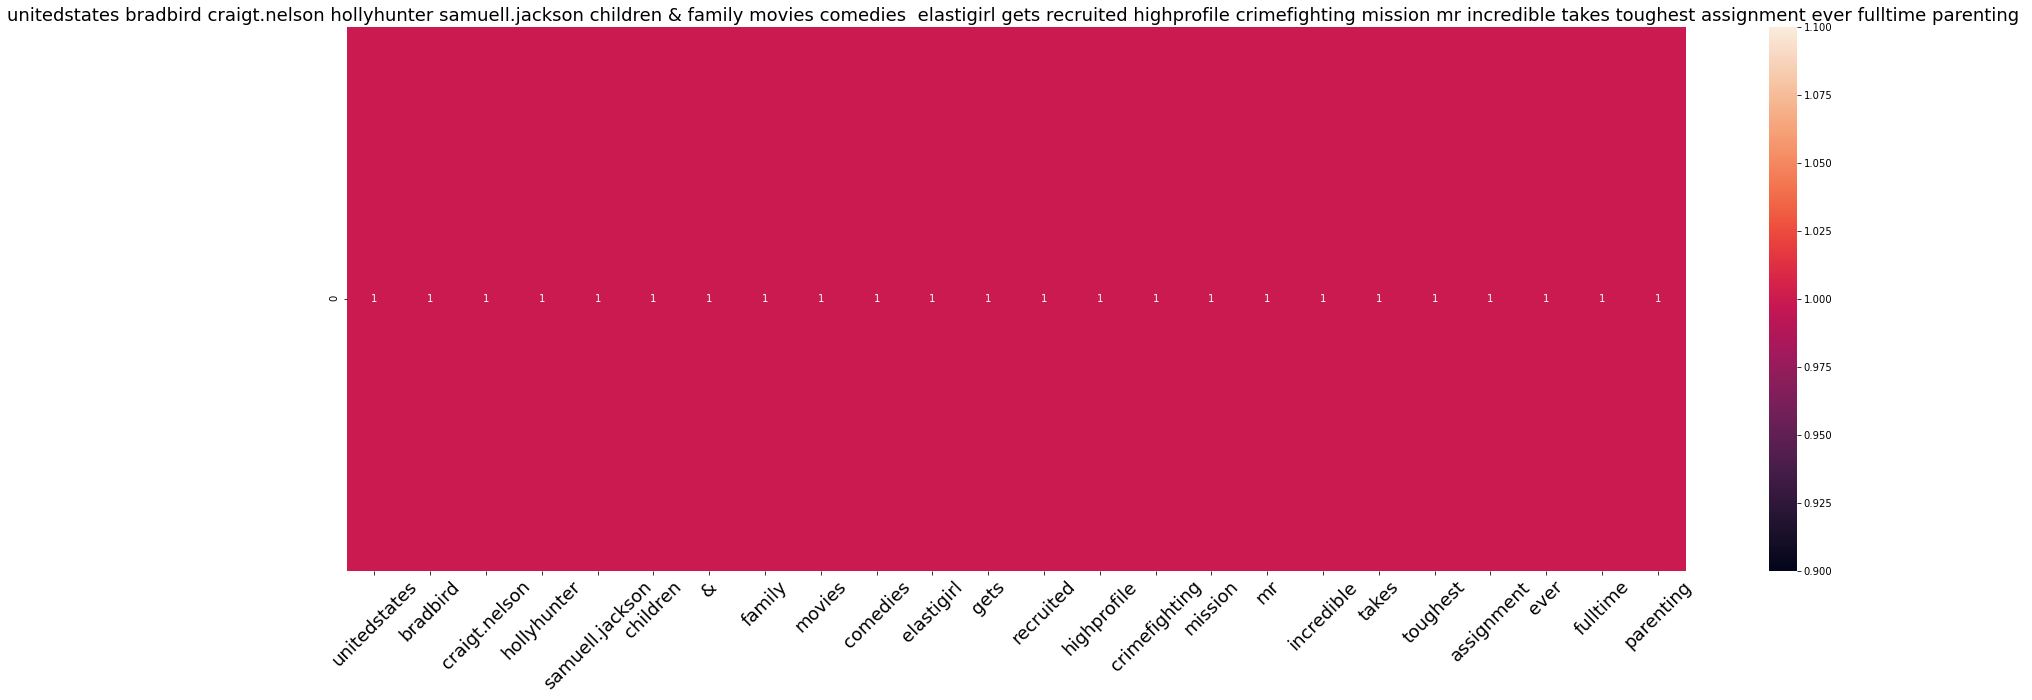

                                                  
Title = Incredibles 2 (Spanish Version)
Story = When Elastigirl gets recruited for a high-profile crime-fighting mission, Mr. Incredible takes on his toughest assignment ever: full-time parenting.
Listed under = Children & Family Movies, Comedies


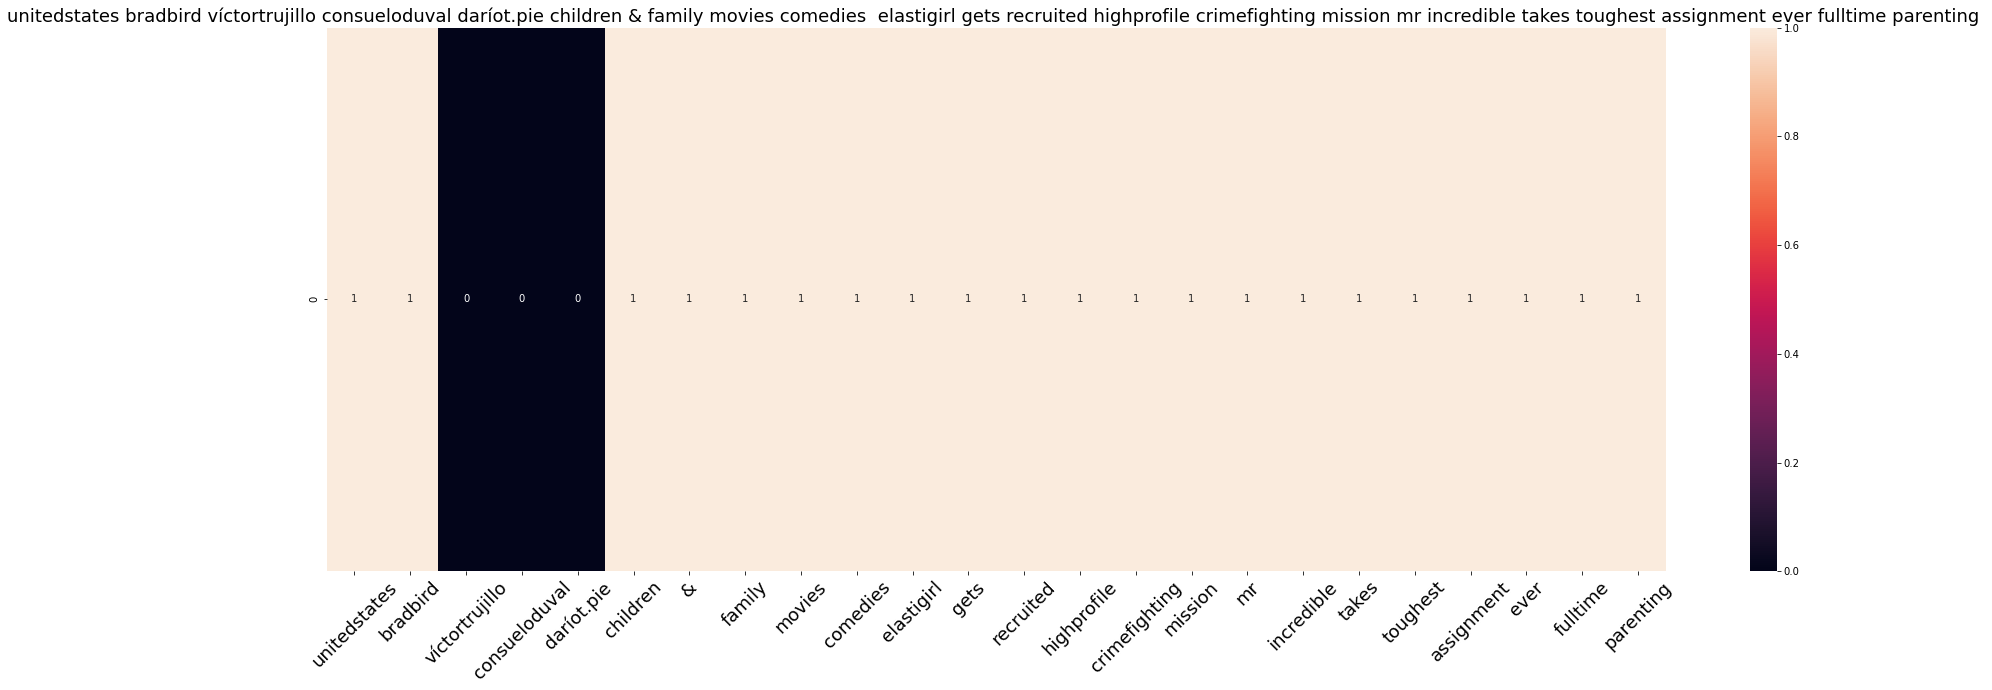

                                                  
Title = DreamWorks Home: For the Holidays
Story = Oh takes it upon himself to introduce Christmas joy to his fellow Boovs. Unfortunately, his well-meaning mission nearly destroys the city.
Listed under = Children & Family Movies, Comedies, Music & Musicals


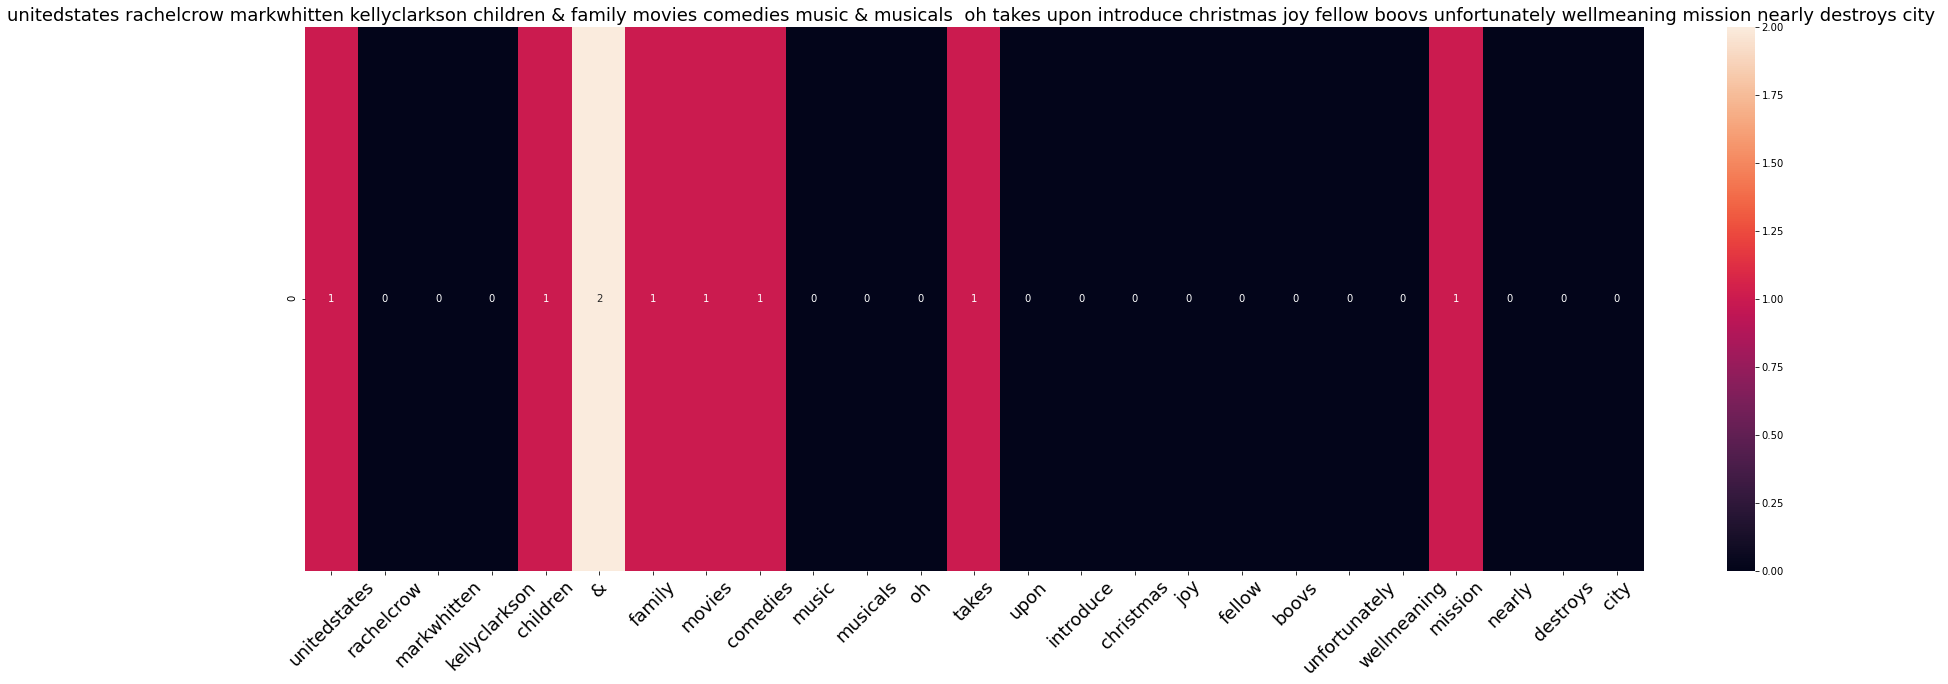

                                                  
Title = Arthur Christmas
Story = At Santa Claus's super-secret toy-making facility, Mr. Claus entrusts his son, Arthur, to carry out an ultra-important Christmas mission.
Listed under = Children & Family Movies, Comedies


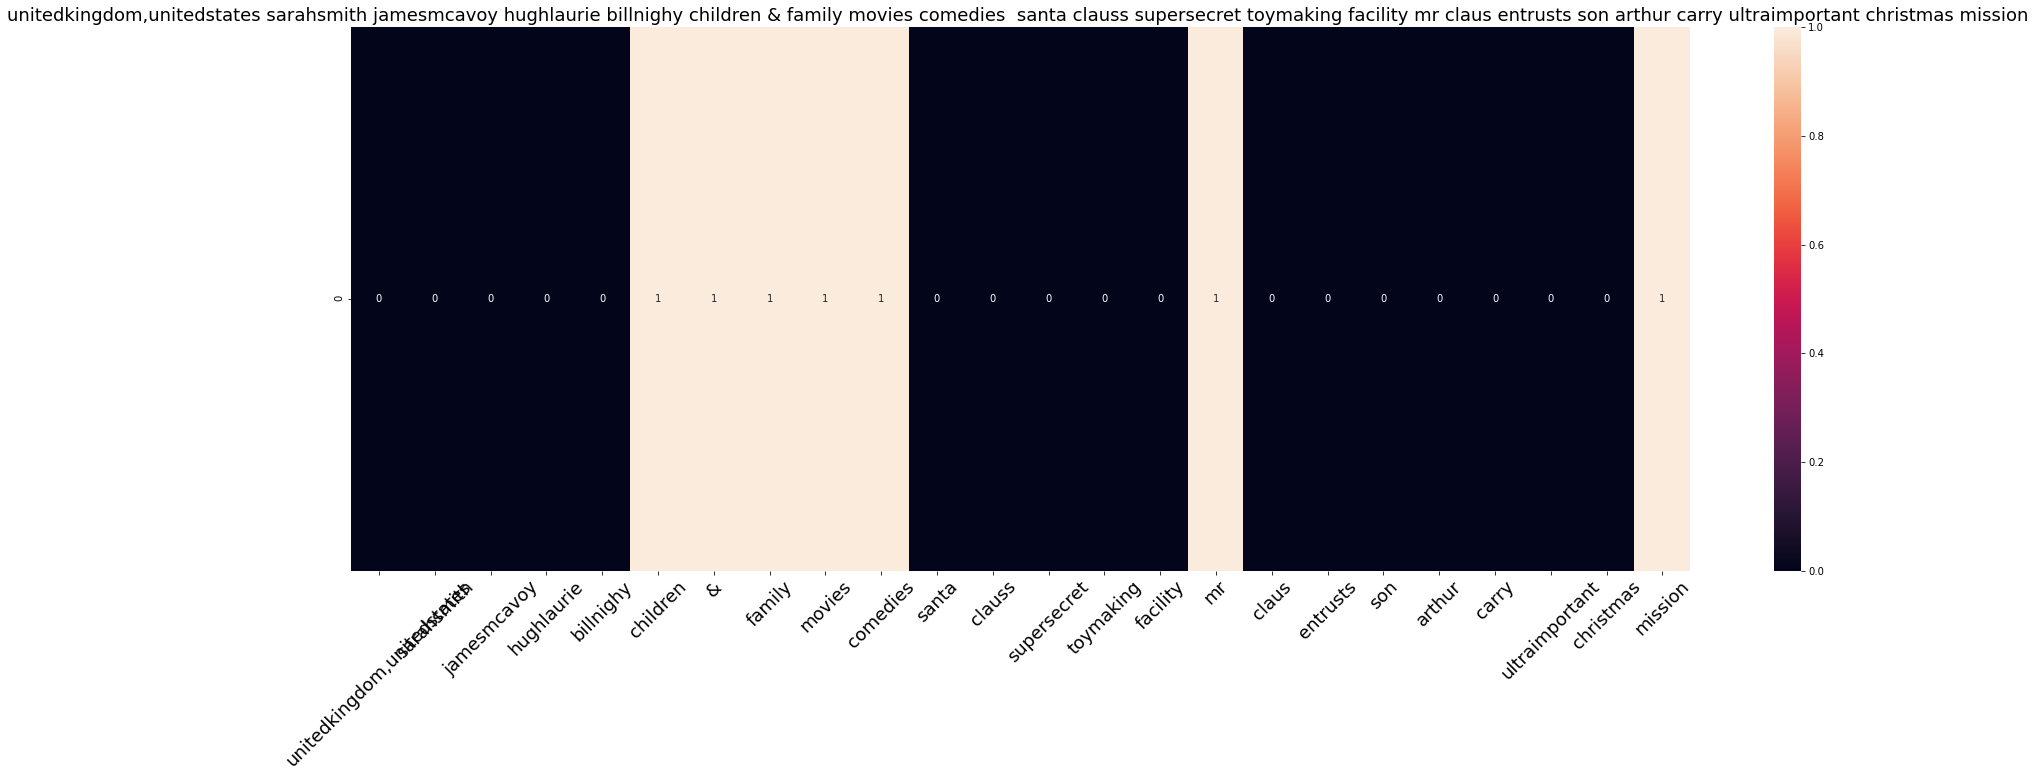

In [21]:
Bag_of_words_model(6487,4)

## TFIDF based movie similarity model

In [22]:
Tfidf_vectorizer = TfidfVectorizer()
Tfidf_title_features = Tfidf_vectorizer.fit_transform(data['text'])

#returns a sparse matrix with dimensions=  no. points * words_in_corpus
# tfidf_title_features[doc_id, index_of_word]= tfidf values of the word in given doc

In [23]:
def Tfidf_model(doc_id,cut_off):
    #doc_id is the number on the new index formed after TfidfVectorizer is applied to the data['text']
    #pairwise distance will save the distance between given input apparel[doc_id] and all other apparels
    pairwise_dist = pairwise_distances(Tfidf_title_features,Tfidf_title_features[doc_id],metric = 'cosine')
    
    #Gives us indices of data points sorted in ascending order based on the eucledian distances
    indices = np.argsort(pairwise_dist.flatten())[:cut_off]
    
    #data indices in our original data set
    data_indices = list(data.index[indices])
    
    for i in range(0,len(data_indices)):
        print('Title = {}'.format(data['title'].loc[data_indices[i]]))
        print('Story = {}'.format(description['description'].loc[data_indices[i]]))
        print('Listed under = {}'.format(description['listed_in'].loc[data_indices[i]]))
        results(indices[i],data['text'].loc[data_indices[0]],data['text'].loc[data_indices[i]],'tf_idf')
        print('         ')
        
        

Title = The Incredibles 2
Story = When Elastigirl gets recruited for a high-profile crime-fighting mission, Mr. Incredible takes on his toughest assignment ever: full-time parenting.
Listed under = Children & Family Movies, Comedies


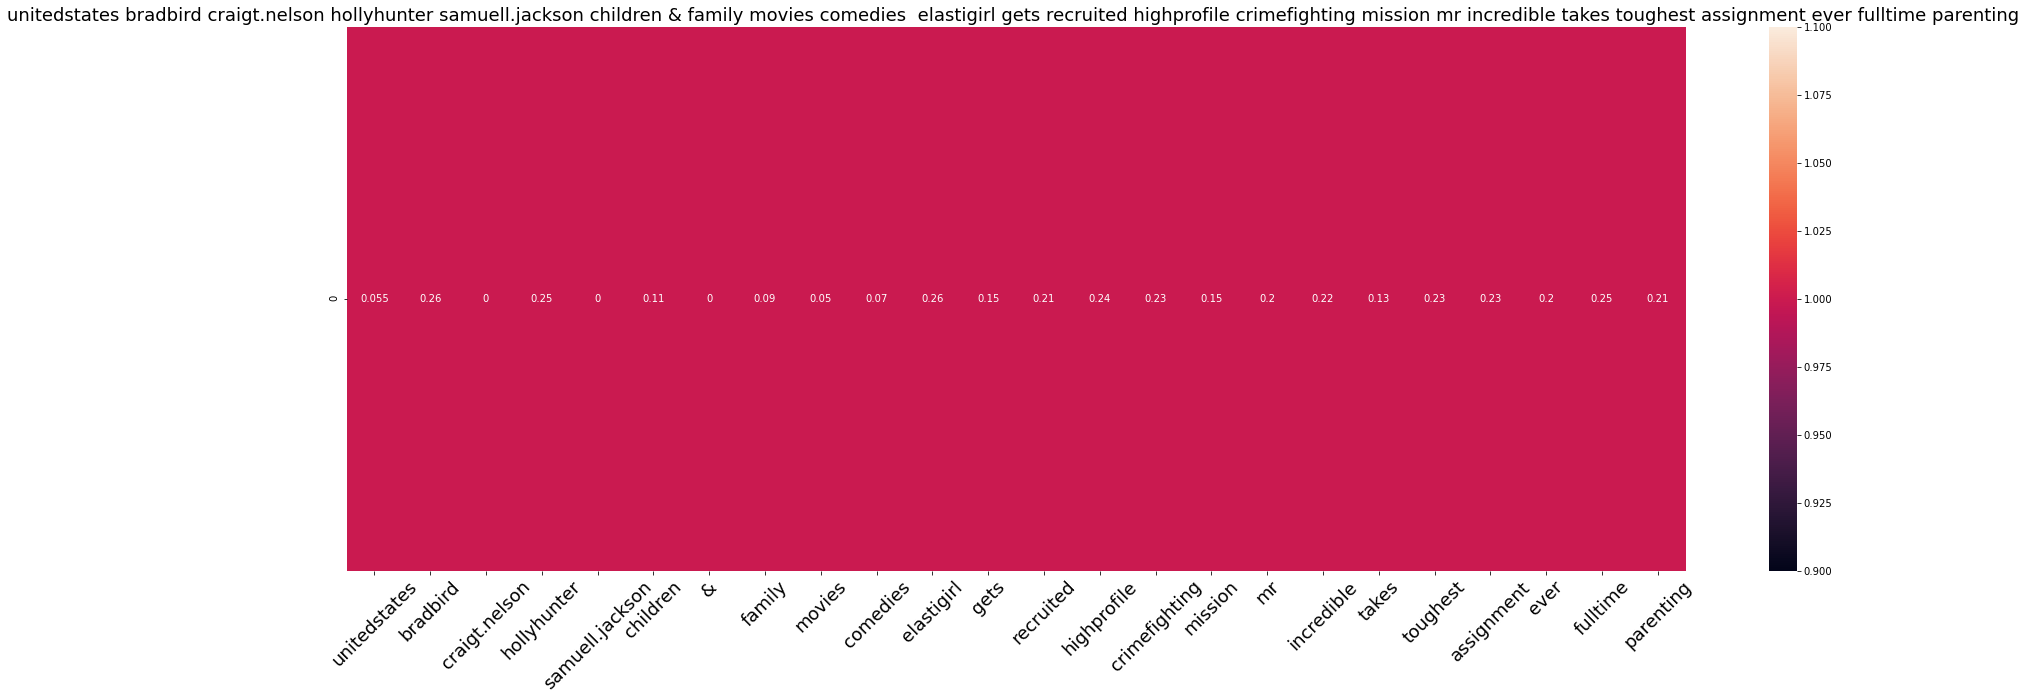

         
Title = Incredibles 2 (Spanish Version)
Story = When Elastigirl gets recruited for a high-profile crime-fighting mission, Mr. Incredible takes on his toughest assignment ever: full-time parenting.
Listed under = Children & Family Movies, Comedies


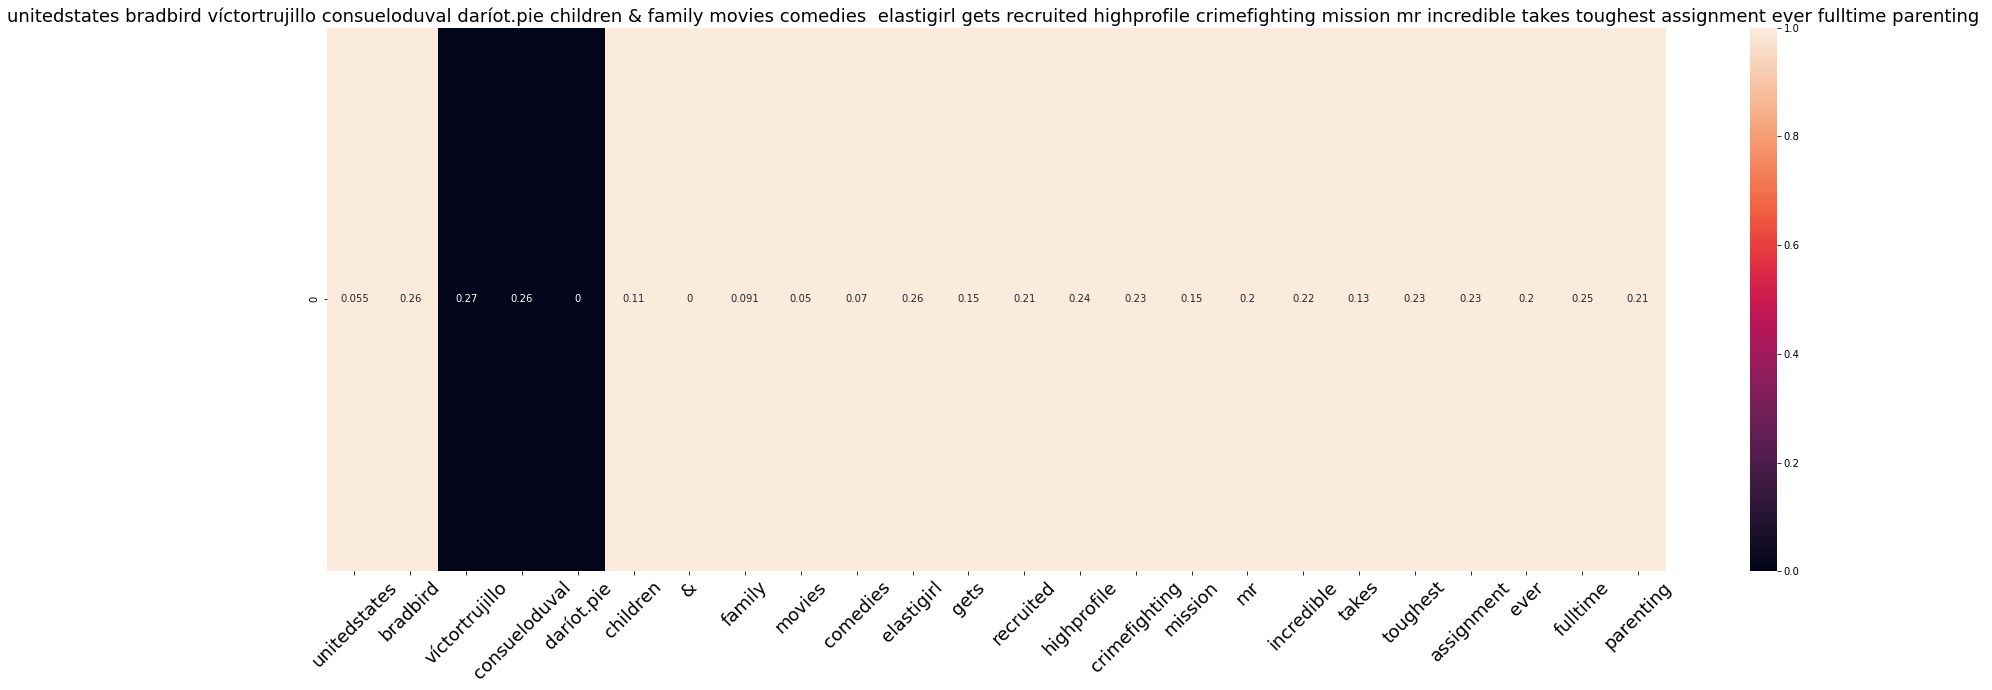

         
Title = Unicorn Store
Story = After failing out of art school and taking a humdrum office job, a whimsical painter gets a chance to fulfill her lifelong dream of adopting a unicorn.
Listed under = Comedies, Dramas, Independent Movies


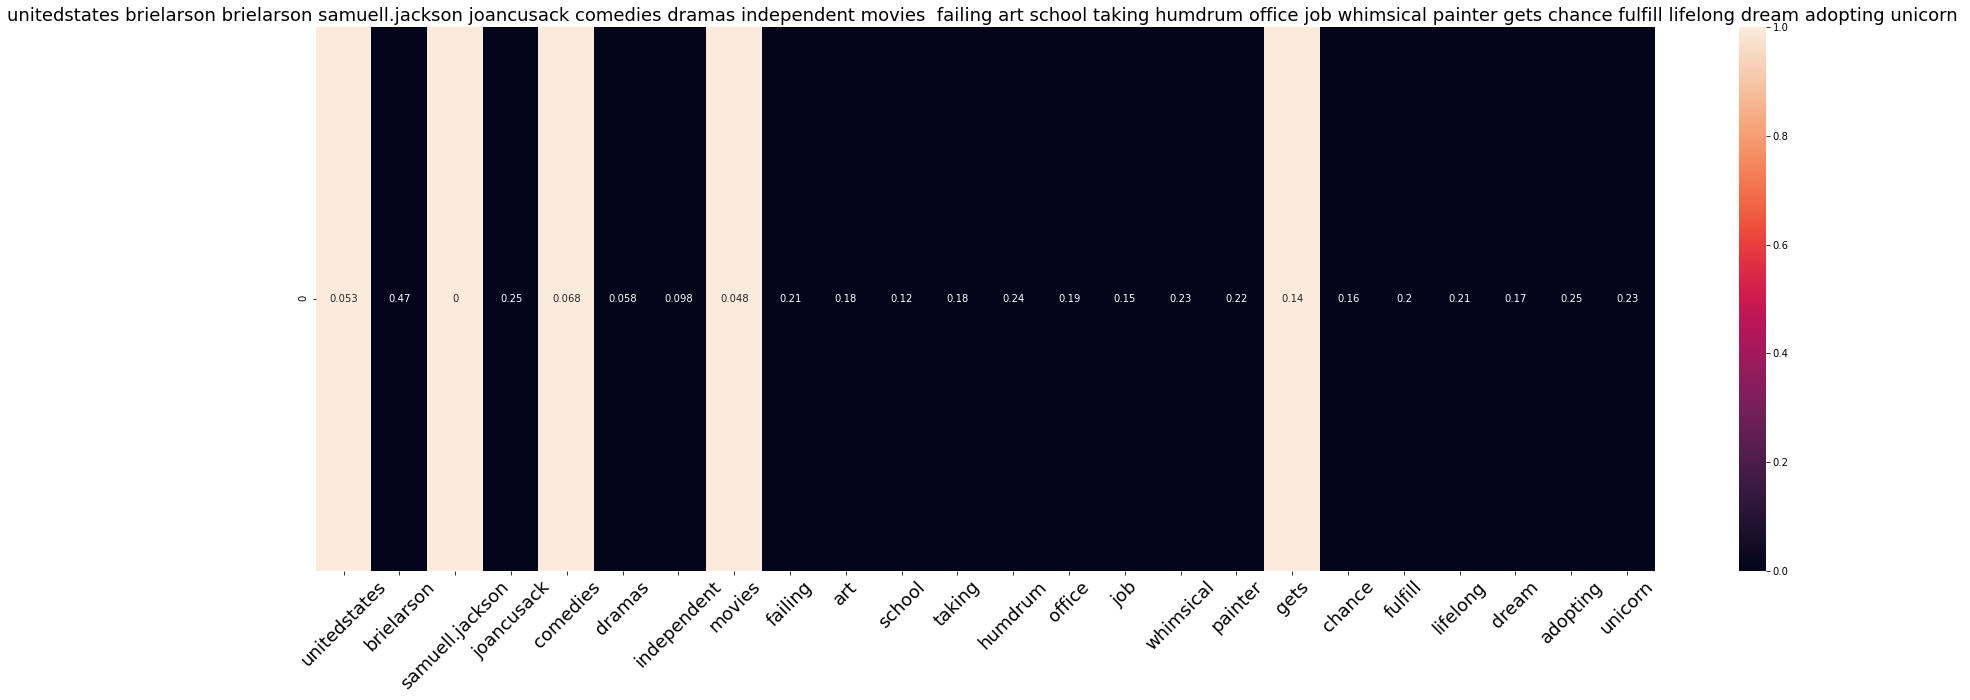

         
Title = Barely Lethal
Story = A girl raised to be a government assassin just wants to be a normal teen – so she runs away and pretends to be a high school exchange student.
Listed under = Action & Adventure, Comedies


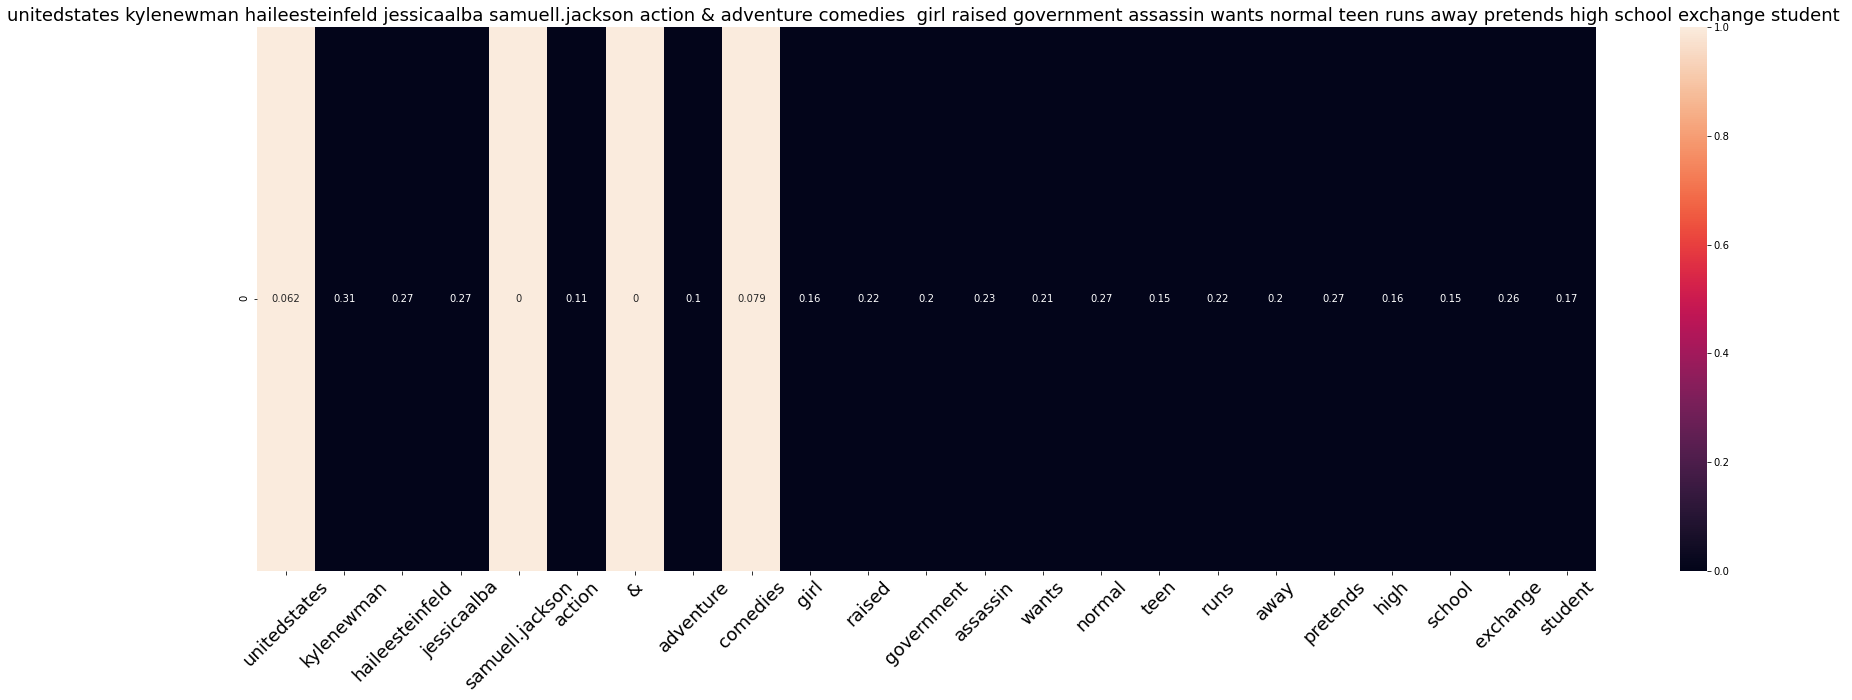

In [24]:
Tfidf_model(6487,4)

# Semantic meaning based apparel similarity

In [38]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# download "GoogleNews-vectors-negative300.bin" 
'''
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)
'''    

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [39]:
'''
#create a dictionary contaning vector representaion from google word2vec of our word corpus

vocab = model.index_to_key
#gives us a list of all the words in google word2vec library

vocab1 = tfidf_title_vectorizer.vocabulary_.keys()
#gives us a list of all the words in our corpus

models = {} 
#empty dictionary

for i in vocab1:
    if i in vocab:
        models.update(i:model[i])
        

#models will contain google's vector representation for our word corpus
'''

"\n#create a dictionary contaning vector representaion from google word2vec of our word corpus\n\nvocab = model.index_to_key\n#gives us a list of all the words in google word2vec library\n\nvocab1 = tfidf_title_vectorizer.vocabulary_.keys()\n#gives us a list of all the words in our corpus\n\nmodels = {} \n#empty dictionary\n\nfor i in vocab1:\n    if i in vocab:\n        models.update(i:model[i])\n        \n\n#models will contain google's vector representation for our word corpus\n"

In [40]:
#uitlity function to better visualize and understand results

def get_word_vec(sentence,model_name):
    #doc_id in our corpus
    #sentence : title of apparel
    #model_name : 'avg', we will append the model[i], w2v representation of word i
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if model_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    return np.array(vec)
def get_distance(vec1,vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
            
    return np.array(final_dist)
def heat_map(sentence1,sentence2,model_name):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # model:  'avg'

    sentence_vec1 = get_word_vec(sentence1,model_name)
    sentence_vec2 = get_word_vec(sentence2,model_name)
    
    #sent1_sent2_dist = eucledian distance between i and j
    #sent1_sent2_dist = np array with dimensions(#number of words in title1 * #number of words in title2)
    sent1_sent2_dist = get_distance(sentence_vec1,sentence_vec2)
    
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(np.round(sent1_sent2_dist,4), annot = True)
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    #setting the fontsize and rotation of x tick tables
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12,rotation=90)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12,rotation=45)
    plt.show()    

## Avg Word2Vec based movie recommendation engine

In [41]:
# this function will add the vectors of each word and returns the avg vector of given sentance

vocab = model.index_to_key
# vocab = stores all the words in google Word2vec model

def avg_word_vec(sentence,no_features,model_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # model_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
    featureVec = np.zeros((no_features,),dtype = "float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if model_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if (nwords>0):
        featureVec = np.divide(featureVec,nwords)
        
    return featureVec

In [42]:
w2v_title_features = []
#for every title we build a vector
for i in data['text']:
    w2v_title_features.append(avg_word_vec(i,300,'avg'))
    
w2v_title_features = np.array(w2v_title_features)

In [43]:
def w2v_model(doc_id,cut_off):
    #doc_id is the number on the new index formed after TfidfVectorizer is applied to the data['text']
    #pairwise distance will save the distance between given input apparel[doc_id] and all other apparels
    pairwise_dist = pairwise_distances(w2v_title_features,w2v_title_features[doc_id].reshape(1,-1))
    
    #Gives us indices of data points sorted in ascending order based on the eucledian distances
    indices = np.argsort(pairwise_dist.flatten())[:cut_off]
    
    #data indices in our original data set
    data_indices = list(data.index[indices])
    
    for i in range(0,len(data_indices)):
        print('Title = {}'.format(data['title'].loc[data_indices[i]]))
        print('Story = {}'.format(description['description'].loc[data_indices[i]]))
        print('Listed under = {}'.format(description['listed_in'].loc[data_indices[i]]))
        heat_map(data['text'].loc[data_indices[0]],data['text'].loc[data_indices[i]],'avg')
        print('    ')

Title = Incredibles 2 (Spanish Version)
Story = When Elastigirl gets recruited for a high-profile crime-fighting mission, Mr. Incredible takes on his toughest assignment ever: full-time parenting.
Listed under = Children & Family Movies, Comedies


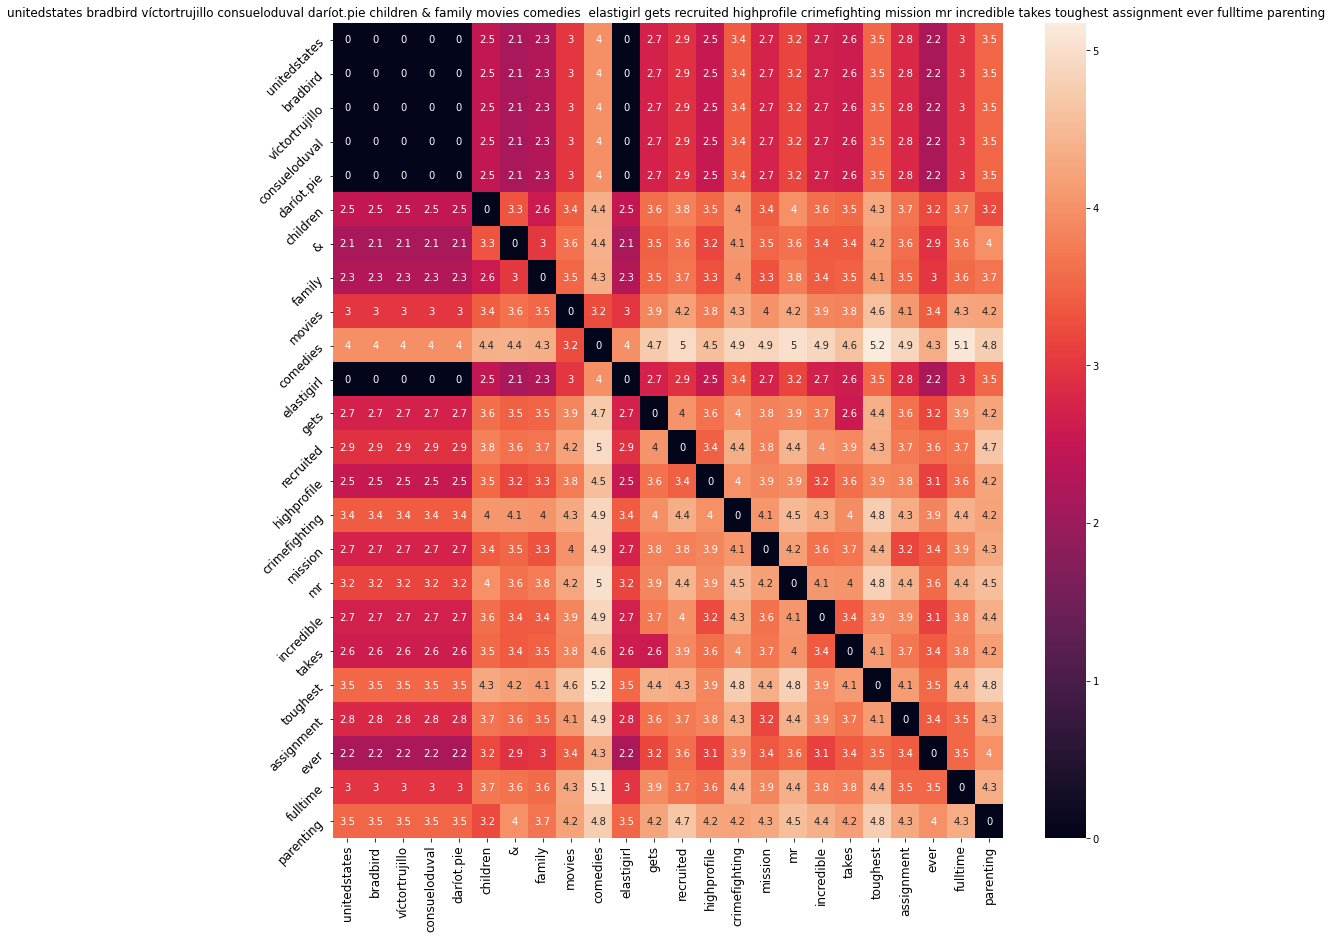

    
Title = The Incredibles 2
Story = When Elastigirl gets recruited for a high-profile crime-fighting mission, Mr. Incredible takes on his toughest assignment ever: full-time parenting.
Listed under = Children & Family Movies, Comedies


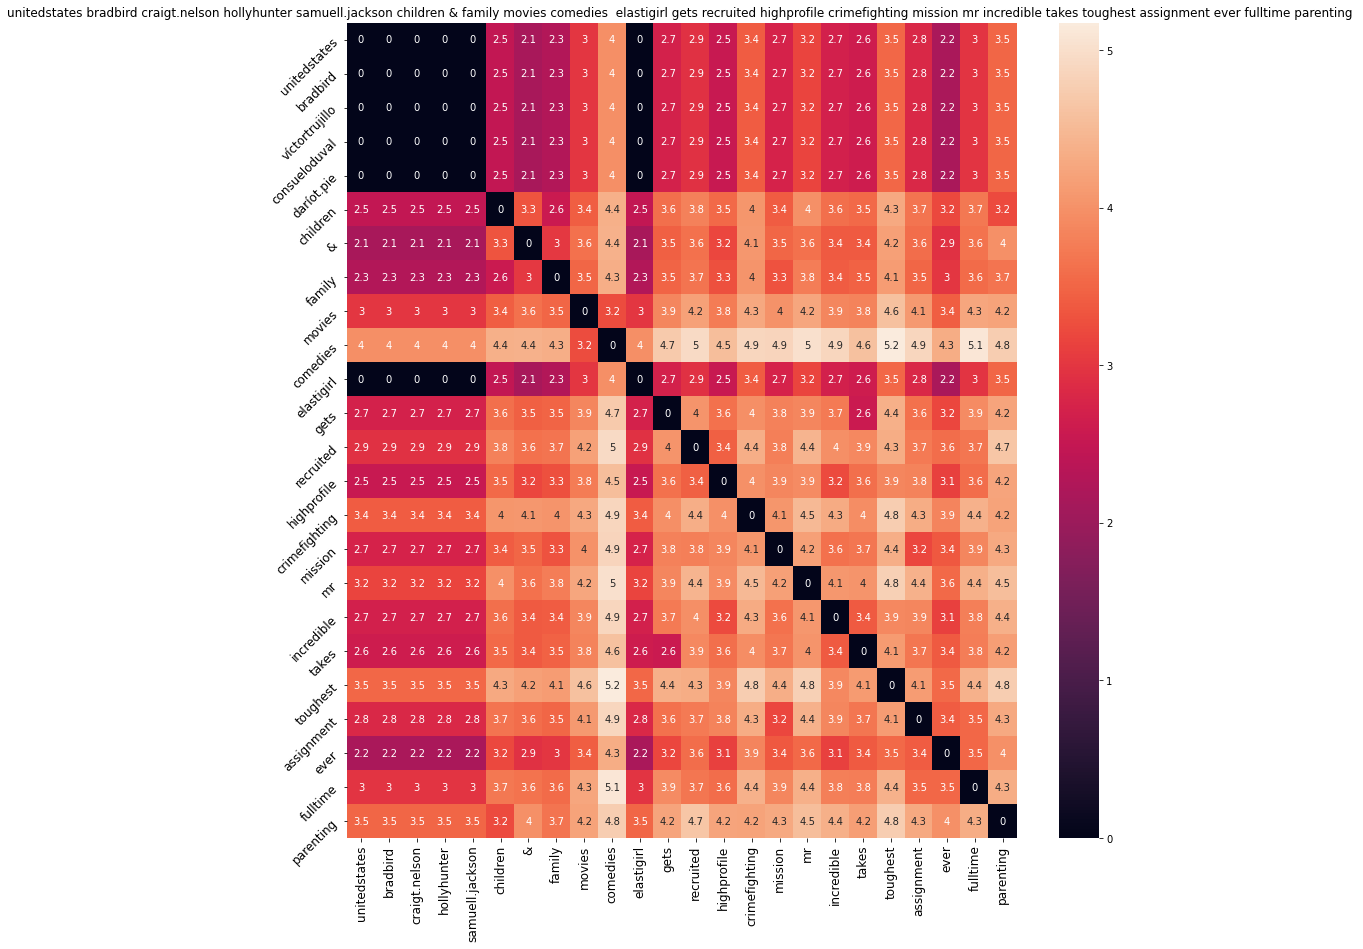

    
Title = The Boss Baby: Get That Baby!
Story = Think you've got what it takes to be the boss? This interactive special puts your skills to the test and matches you up with one of 16 jobs at Baby Corp.
Listed under = Children & Family Movies, Comedies


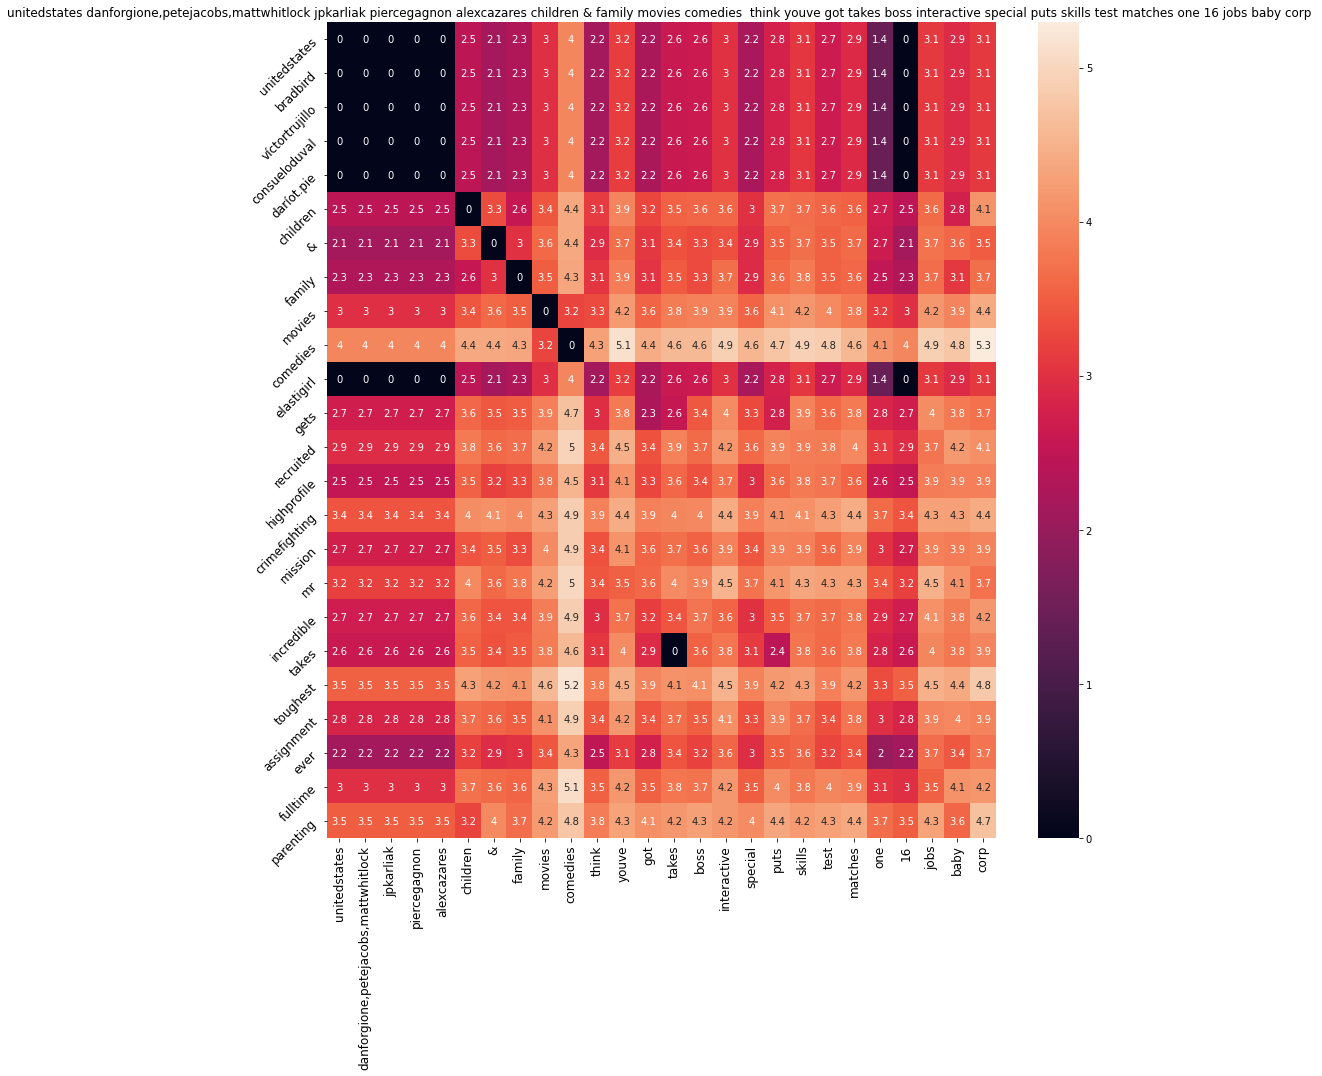

    
Title = Daddy Day Care
Story = When a conscientious father loses his lucrative dot-com job and faces economic ruin, he joins two friends in opening a business called Daddy Day Care.
Listed under = Children & Family Movies, Comedies


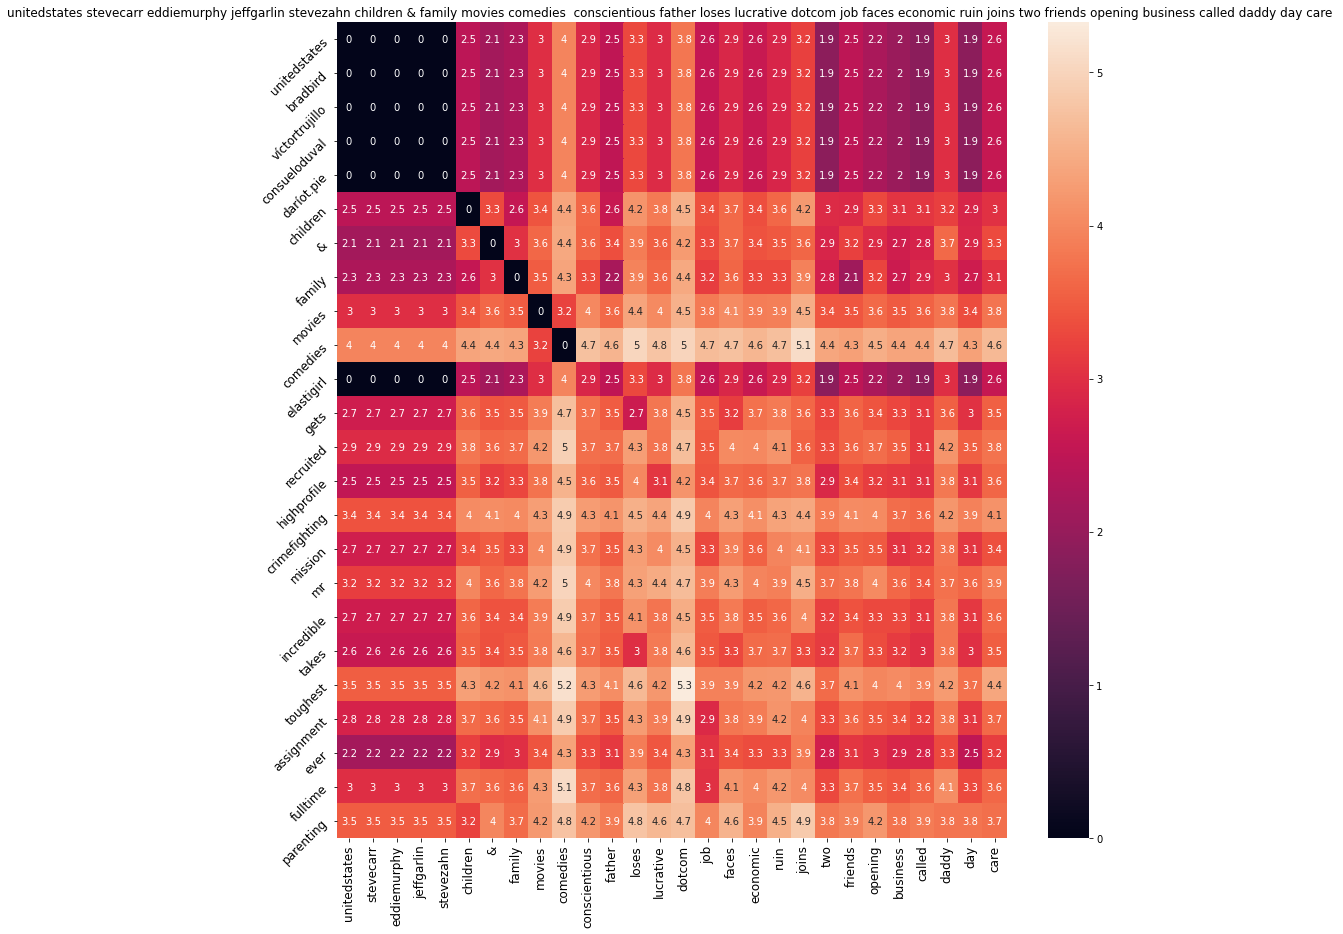

In [44]:
w2v_model(6487,4)
# Have described a utility function above

# Conclusion:
Reflection:
The purpose of the project is to make an movie/TV show recommendation engine for Netflix. We are given simulated data that gives us various characteristics of the content on Netflix. The recommendations are to be made based on these characteristics of the content and hence, we are building a content based fliter recommendation system.

#### Text preprocessing: 
After initial data analysis and data cleaning, we build our text data by merging 'decription', 'cast', 'director', 'listed_in' and 'country' features which describes the various characteristices of a movie/Tv series into a single string of words. At first we need to preprocess these features to make them relevant before merging them into a string describing a movie/ Tv Show. We go about this as follows :

1. Merge all the first names and last names of 'cast' and 'directors' into one unique word and also lower the text. Let me explain why we do so with the help of an example, suppose we have movie X where the name of actor is jennifer aniston, and movie Y where the director is jennifer lawrence, the recommender will detect a similarity because of the same first names and that is something we would want to avoid. We would prefer the recommender to only consider a similarity if the person associated to different movies is exactly the same person.
 
2. We also lower and merge the words in our 'country' name 'feature' to create a unique word to avoid the same problem mentioned above.
 